# Ungraded Lab: Build a Multi-output Model

In this lab, we'll show how you can build models with more than one output. The dataset we will be working on is available from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Energy+efficiency). It is an Energy Efficiency dataset which uses the bulding features (e.g. wall area, roof area) as inputs and has two outputs: Cooling Load and Heating Load. Let's see how we can build a model to train on this data.

## Imports

In [1]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
from sklearn.model_selection import train_test_split

## Utilities

We define a few utilities for data conversion and visualization to make our code more neat.

In [2]:
def format_output(data):
    y1 = data.pop('Y1')
    y1 = np.array(y1)
    y2 = data.pop('Y2')
    y2 = np.array(y2)
    return y1, y2


def norm(x):
    return (x - train_stats['mean']) / train_stats['std']


def plot_diff(y_true, y_pred, title=''):
    plt.scatter(y_true, y_pred)
    plt.title(title)
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.axis('equal')
    plt.axis('square')
    plt.xlim(plt.xlim())
    plt.ylim(plt.ylim())
    plt.plot([-100, 100], [-100, 100])
    plt.show()


def plot_metrics(metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0, ylim)
    plt.plot(history.history[metric_name], color='blue', label=metric_name)
    plt.plot(history.history['val_' + metric_name], color='green', label='val_' + metric_name)
    plt.show()

## Prepare the Data

We download the dataset and format it for training.

In [3]:
# Specify data URI
URI = './data/ENB2012_data.xlsx'

# Use pandas excel reader
df = pd.read_excel(URI)
df = df.sample(frac=1).reset_index(drop=True)

# Split the data into train and test with 80 train / 20 test
train, test = train_test_split(df, test_size=0.2)
train_stats = train.describe()

# Get Y1 and Y2 as the 2 outputs and format them as np arrays
train_stats.pop('Y1')
train_stats.pop('Y2')
train_stats = train_stats.transpose()
train_Y = format_output(train)
test_Y = format_output(test)

# Normalize the training and test data
norm_train_X = norm(train)
norm_test_X = norm(test)

## Build the Model

Here is how we'll build the model using the functional syntax. Notice that we can specify a list of outputs (i.e. `[y1_output, y2_output]`) when we instantiate the `Model()` class.

In [4]:
# Define model layers.
input_layer = Input(shape=(len(train .columns),))
first_dense = Dense(units='128', activation='relu')(input_layer)
second_dense = Dense(units='128', activation='relu')(first_dense)

# Y1 output will be fed directly from the second dense
y1_output = Dense(units='1', name='y1_output')(second_dense)
third_dense = Dense(units='64', activation='relu')(second_dense)

# Y2 output will come via the third dense
y2_output = Dense(units='1', name='y2_output')(third_dense)

# Define the model with the input layer and a list of output layers
model = Model(inputs=input_layer, outputs=[y1_output, y2_output])

print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 8)]          0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 128)          1152        input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 128)          16512       dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 64)           8256        dense_1[0][0]                    
______________________________________________________________________________________________

## Configure parameters

We specify the optimizer as well as the loss and metrics for each output.

In [5]:
# Specify the optimizer, and compile the model with loss functions for both outputs
optimizer = tf.keras.optimizers.SGD(lr=0.001)
model.compile(optimizer=optimizer,
              loss={'y1_output': 'mse', 'y2_output': 'mse'},
              metrics={'y1_output': tf.keras.metrics.RootMeanSquaredError(),
                       'y2_output': tf.keras.metrics.RootMeanSquaredError()})

## Train the Model

In [6]:
# Train the model for 500 epochs
history = model.fit(norm_train_X, train_Y,
                    epochs=500, batch_size=10, validation_data=(norm_test_X, test_Y))

Train on 614 samples, validate on 154 samples
Epoch 1/500
614/614 [==============================] - 1s 938us/sample - loss: 230.6880 - y1_output_loss: 110.5080 - y2_output_loss: 118.1284 - y1_output_root_mean_squared_error: 10.5604 - y2_output_root_mean_squared_error: 10.9163 - val_loss: 25.5178 - val_y1_output_loss: 12.8251 - val_y2_output_loss: 15.6318 - val_y1_output_root_mean_squared_error: 3.4494 - val_y2_output_root_mean_squared_error: 3.6905
Epoch 2/500
614/614 [==============================] - 0s 143us/sample - loss: 31.6210 - y1_output_loss: 12.9788 - y2_output_loss: 18.5397 - y1_output_root_mean_squared_error: 3.6000 - y2_output_root_mean_squared_error: 4.3199 - val_loss: 28.4629 - val_y1_output_loss: 10.6256 - val_y2_output_loss: 17.7420 - val_y1_output_root_mean_squared_error: 3.2742 - val_y2_output_root_mean_squared_error: 4.2122
Epoch 3/500
614/614 [==============================] - 0s 142us/sample - loss: 28.3585 - y1_output_loss: 10.7450 - y2_output_loss: 17.5194 - y1

614/614 [==============================] - 0s 136us/sample - loss: 15.2460 - y1_output_loss: 5.9827 - y2_output_loss: 9.2131 - y1_output_root_mean_squared_error: 2.4554 - y2_output_root_mean_squared_error: 3.0360 - val_loss: 12.9615 - val_y1_output_loss: 5.5364 - val_y2_output_loss: 7.7234 - val_y1_output_root_mean_squared_error: 2.3625 - val_y2_output_root_mean_squared_error: 2.7167
Epoch 22/500
614/614 [==============================] - 0s 133us/sample - loss: 13.6643 - y1_output_loss: 5.2764 - y2_output_loss: 8.4871 - y1_output_root_mean_squared_error: 2.2871 - y2_output_root_mean_squared_error: 2.9041 - val_loss: 25.2209 - val_y1_output_loss: 9.2423 - val_y2_output_loss: 16.8957 - val_y1_output_root_mean_squared_error: 2.9998 - val_y2_output_root_mean_squared_error: 4.0276
Epoch 23/500
614/614 [==============================] - 0s 137us/sample - loss: 14.5358 - y1_output_loss: 5.2415 - y2_output_loss: 9.2383 - y1_output_root_mean_squared_error: 2.2974 - y2_output_root_mean_squared_

614/614 [==============================] - 0s 130us/sample - loss: 7.8888 - y1_output_loss: 2.5537 - y2_output_loss: 5.3545 - y1_output_root_mean_squared_error: 1.5876 - y2_output_root_mean_squared_error: 2.3170 - val_loss: 11.7990 - val_y1_output_loss: 4.1608 - val_y2_output_loss: 8.0694 - val_y1_output_root_mean_squared_error: 2.0166 - val_y2_output_root_mean_squared_error: 2.7807
Epoch 42/500
614/614 [==============================] - 0s 131us/sample - loss: 6.6746 - y1_output_loss: 2.2455 - y2_output_loss: 4.3728 - y1_output_root_mean_squared_error: 1.5049 - y2_output_root_mean_squared_error: 2.1000 - val_loss: 6.8589 - val_y1_output_loss: 2.3943 - val_y2_output_loss: 4.6349 - val_y1_output_root_mean_squared_error: 1.5292 - val_y2_output_root_mean_squared_error: 2.1261
Epoch 43/500
614/614 [==============================] - 0s 137us/sample - loss: 9.5669 - y1_output_loss: 2.7414 - y2_output_loss: 6.8123 - y1_output_root_mean_squared_error: 1.6622 - y2_output_root_mean_squared_error

Epoch 62/500
614/614 [==============================] - 0s 136us/sample - loss: 4.5596 - y1_output_loss: 1.2951 - y2_output_loss: 3.2343 - y1_output_root_mean_squared_error: 1.1387 - y2_output_root_mean_squared_error: 1.8064 - val_loss: 4.7261 - val_y1_output_loss: 1.4044 - val_y2_output_loss: 3.4656 - val_y1_output_root_mean_squared_error: 1.1613 - val_y2_output_root_mean_squared_error: 1.8378
Epoch 63/500
614/614 [==============================] - 0s 135us/sample - loss: 5.5173 - y1_output_loss: 1.6792 - y2_output_loss: 3.8754 - y1_output_root_mean_squared_error: 1.3008 - y2_output_root_mean_squared_error: 1.9558 - val_loss: 9.8339 - val_y1_output_loss: 1.7973 - val_y2_output_loss: 8.5127 - val_y1_output_root_mean_squared_error: 1.3317 - val_y2_output_root_mean_squared_error: 2.8391
Epoch 64/500
614/614 [==============================] - 0s 135us/sample - loss: 4.4322 - y1_output_loss: 1.2660 - y2_output_loss: 3.1531 - y1_output_root_mean_squared_error: 1.1228 - y2_output_root_mean_s

Epoch 83/500
614/614 [==============================] - 0s 144us/sample - loss: 3.7049 - y1_output_loss: 0.9018 - y2_output_loss: 2.7894 - y1_output_root_mean_squared_error: 0.9471 - y2_output_root_mean_squared_error: 1.6757 - val_loss: 3.5957 - val_y1_output_loss: 1.1224 - val_y2_output_loss: 2.4563 - val_y1_output_root_mean_squared_error: 1.0692 - val_y2_output_root_mean_squared_error: 1.5660
Epoch 84/500
614/614 [==============================] - 0s 148us/sample - loss: 3.5335 - y1_output_loss: 0.9381 - y2_output_loss: 2.6226 - y1_output_root_mean_squared_error: 0.9685 - y2_output_root_mean_squared_error: 1.6110 - val_loss: 5.5402 - val_y1_output_loss: 1.7430 - val_y2_output_loss: 3.6899 - val_y1_output_root_mean_squared_error: 1.3405 - val_y2_output_root_mean_squared_error: 1.9348
Epoch 85/500
614/614 [==============================] - 0s 142us/sample - loss: 2.8266 - y1_output_loss: 0.7680 - y2_output_loss: 2.0818 - y1_output_root_mean_squared_error: 0.8763 - y2_output_root_mean_s

Epoch 104/500
614/614 [==============================] - 0s 136us/sample - loss: 2.1835 - y1_output_loss: 0.5170 - y2_output_loss: 1.6806 - y1_output_root_mean_squared_error: 0.7143 - y2_output_root_mean_squared_error: 1.2935 - val_loss: 6.1791 - val_y1_output_loss: 1.1522 - val_y2_output_loss: 5.2926 - val_y1_output_root_mean_squared_error: 1.0639 - val_y2_output_root_mean_squared_error: 2.2466
Epoch 105/500
614/614 [==============================] - 0s 137us/sample - loss: 2.3549 - y1_output_loss: 0.5175 - y2_output_loss: 1.8237 - y1_output_root_mean_squared_error: 0.7207 - y2_output_root_mean_squared_error: 1.3548 - val_loss: 3.0663 - val_y1_output_loss: 0.9201 - val_y2_output_loss: 2.1208 - val_y1_output_root_mean_squared_error: 0.9698 - val_y2_output_root_mean_squared_error: 1.4580
Epoch 106/500
614/614 [==============================] - 0s 139us/sample - loss: 2.2507 - y1_output_loss: 0.5152 - y2_output_loss: 1.7260 - y1_output_root_mean_squared_error: 0.7189 - y2_output_root_mea

614/614 [==============================] - 0s 134us/sample - loss: 3.0557 - y1_output_loss: 0.8007 - y2_output_loss: 2.2447 - y1_output_root_mean_squared_error: 0.8991 - y2_output_root_mean_squared_error: 1.4991 - val_loss: 2.3568 - val_y1_output_loss: 0.5005 - val_y2_output_loss: 1.9706 - val_y1_output_root_mean_squared_error: 0.7040 - val_y2_output_root_mean_squared_error: 1.3643
Epoch 125/500
614/614 [==============================] - 0s 137us/sample - loss: 2.1295 - y1_output_loss: 0.4564 - y2_output_loss: 1.6629 - y1_output_root_mean_squared_error: 0.6751 - y2_output_root_mean_squared_error: 1.2938 - val_loss: 2.5406 - val_y1_output_loss: 0.6353 - val_y2_output_loss: 1.8915 - val_y1_output_root_mean_squared_error: 0.8053 - val_y2_output_root_mean_squared_error: 1.3756
Epoch 126/500
614/614 [==============================] - 0s 137us/sample - loss: 1.9741 - y1_output_loss: 0.4611 - y2_output_loss: 1.4972 - y1_output_root_mean_squared_error: 0.6815 - y2_output_root_mean_squared_erro

Epoch 145/500
614/614 [==============================] - 0s 146us/sample - loss: 1.8475 - y1_output_loss: 0.3477 - y2_output_loss: 1.4885 - y1_output_root_mean_squared_error: 0.5924 - y2_output_root_mean_squared_error: 1.2233 - val_loss: 2.1220 - val_y1_output_loss: 0.3973 - val_y2_output_loss: 1.7695 - val_y1_output_root_mean_squared_error: 0.6377 - val_y2_output_root_mean_squared_error: 1.3097
Epoch 146/500
614/614 [==============================] - 0s 148us/sample - loss: 1.5729 - y1_output_loss: 0.3268 - y2_output_loss: 1.2495 - y1_output_root_mean_squared_error: 0.5699 - y2_output_root_mean_squared_error: 1.1172 - val_loss: 2.2289 - val_y1_output_loss: 0.4010 - val_y2_output_loss: 1.8617 - val_y1_output_root_mean_squared_error: 0.6361 - val_y2_output_root_mean_squared_error: 1.3507
Epoch 147/500
614/614 [==============================] - 0s 148us/sample - loss: 1.7805 - y1_output_loss: 0.4029 - y2_output_loss: 1.3660 - y1_output_root_mean_squared_error: 0.6348 - y2_output_root_mea

614/614 [==============================] - 0s 134us/sample - loss: 1.3520 - y1_output_loss: 0.2890 - y2_output_loss: 1.1041 - y1_output_root_mean_squared_error: 0.5396 - y2_output_root_mean_squared_error: 1.0300 - val_loss: 2.3737 - val_y1_output_loss: 0.4353 - val_y2_output_loss: 1.9043 - val_y1_output_root_mean_squared_error: 0.6712 - val_y2_output_root_mean_squared_error: 1.3868
Epoch 166/500
614/614 [==============================] - 0s 135us/sample - loss: 1.4892 - y1_output_loss: 0.3238 - y2_output_loss: 1.1662 - y1_output_root_mean_squared_error: 0.5665 - y2_output_root_mean_squared_error: 1.0808 - val_loss: 2.2365 - val_y1_output_loss: 0.3894 - val_y2_output_loss: 1.9533 - val_y1_output_root_mean_squared_error: 0.6282 - val_y2_output_root_mean_squared_error: 1.3571
Epoch 167/500
614/614 [==============================] - 0s 140us/sample - loss: 1.5346 - y1_output_loss: 0.3120 - y2_output_loss: 1.2434 - y1_output_root_mean_squared_error: 0.5610 - y2_output_root_mean_squared_erro

Epoch 186/500
614/614 [==============================] - 0s 137us/sample - loss: 1.8436 - y1_output_loss: 0.4631 - y2_output_loss: 1.3800 - y1_output_root_mean_squared_error: 0.6799 - y2_output_root_mean_squared_error: 1.1753 - val_loss: 4.5208 - val_y1_output_loss: 0.9808 - val_y2_output_loss: 3.6468 - val_y1_output_root_mean_squared_error: 0.9966 - val_y2_output_root_mean_squared_error: 1.8782
Epoch 187/500
614/614 [==============================] - 0s 140us/sample - loss: 1.4386 - y1_output_loss: 0.3256 - y2_output_loss: 1.1201 - y1_output_root_mean_squared_error: 0.5713 - y2_output_root_mean_squared_error: 1.0546 - val_loss: 2.3210 - val_y1_output_loss: 0.6404 - val_y2_output_loss: 1.6776 - val_y1_output_root_mean_squared_error: 0.8125 - val_y2_output_root_mean_squared_error: 1.2888
Epoch 188/500
614/614 [==============================] - 0s 136us/sample - loss: 1.0831 - y1_output_loss: 0.2705 - y2_output_loss: 0.8097 - y1_output_root_mean_squared_error: 0.5220 - y2_output_root_mea

614/614 [==============================] - 0s 130us/sample - loss: 1.2061 - y1_output_loss: 0.2687 - y2_output_loss: 0.9287 - y1_output_root_mean_squared_error: 0.5197 - y2_output_root_mean_squared_error: 0.9675 - val_loss: 1.6691 - val_y1_output_loss: 0.1898 - val_y2_output_loss: 1.5016 - val_y1_output_root_mean_squared_error: 0.4437 - val_y2_output_root_mean_squared_error: 1.2133
Epoch 207/500
614/614 [==============================] - 0s 130us/sample - loss: 1.1454 - y1_output_loss: 0.2629 - y2_output_loss: 0.8812 - y1_output_root_mean_squared_error: 0.5151 - y2_output_root_mean_squared_error: 0.9381 - val_loss: 1.8496 - val_y1_output_loss: 0.2344 - val_y2_output_loss: 1.6003 - val_y1_output_root_mean_squared_error: 0.4887 - val_y2_output_root_mean_squared_error: 1.2692
Epoch 208/500
614/614 [==============================] - 0s 135us/sample - loss: 1.5004 - y1_output_loss: 0.2755 - y2_output_loss: 1.2144 - y1_output_root_mean_squared_error: 0.5256 - y2_output_root_mean_squared_erro

Epoch 227/500
614/614 [==============================] - 0s 131us/sample - loss: 1.1575 - y1_output_loss: 0.2308 - y2_output_loss: 0.9236 - y1_output_root_mean_squared_error: 0.4785 - y2_output_root_mean_squared_error: 0.9636 - val_loss: 1.6752 - val_y1_output_loss: 0.3419 - val_y2_output_loss: 1.3145 - val_y1_output_root_mean_squared_error: 0.5936 - val_y2_output_root_mean_squared_error: 1.1502
Epoch 228/500
614/614 [==============================] - 0s 132us/sample - loss: 1.0846 - y1_output_loss: 0.2668 - y2_output_loss: 0.8176 - y1_output_root_mean_squared_error: 0.5152 - y2_output_root_mean_squared_error: 0.9051 - val_loss: 1.5605 - val_y1_output_loss: 0.1742 - val_y2_output_loss: 1.4226 - val_y1_output_root_mean_squared_error: 0.4240 - val_y2_output_root_mean_squared_error: 1.1750
Epoch 229/500
614/614 [==============================] - 0s 132us/sample - loss: 1.0989 - y1_output_loss: 0.2391 - y2_output_loss: 0.8533 - y1_output_root_mean_squared_error: 0.4904 - y2_output_root_mea

614/614 [==============================] - 0s 148us/sample - loss: 0.9382 - y1_output_loss: 0.1918 - y2_output_loss: 0.7542 - y1_output_root_mean_squared_error: 0.4396 - y2_output_root_mean_squared_error: 0.8631 - val_loss: 2.9261 - val_y1_output_loss: 0.2647 - val_y2_output_loss: 2.5938 - val_y1_output_root_mean_squared_error: 0.5238 - val_y2_output_root_mean_squared_error: 1.6284
Epoch 248/500
614/614 [==============================] - 0s 133us/sample - loss: 0.8955 - y1_output_loss: 0.2021 - y2_output_loss: 0.6888 - y1_output_root_mean_squared_error: 0.4492 - y2_output_root_mean_squared_error: 0.8329 - val_loss: 1.2784 - val_y1_output_loss: 0.2037 - val_y2_output_loss: 1.1231 - val_y1_output_root_mean_squared_error: 0.4537 - val_y2_output_root_mean_squared_error: 1.0357
Epoch 249/500
614/614 [==============================] - 0s 138us/sample - loss: 0.8568 - y1_output_loss: 0.1997 - y2_output_loss: 0.6667 - y1_output_root_mean_squared_error: 0.4468 - y2_output_root_mean_squared_erro

Epoch 268/500
614/614 [==============================] - 0s 136us/sample - loss: 0.8252 - y1_output_loss: 0.1949 - y2_output_loss: 0.6272 - y1_output_root_mean_squared_error: 0.4428 - y2_output_root_mean_squared_error: 0.7931 - val_loss: 1.6436 - val_y1_output_loss: 0.2399 - val_y2_output_loss: 1.4203 - val_y1_output_root_mean_squared_error: 0.4957 - val_y2_output_root_mean_squared_error: 1.1823
Epoch 269/500
614/614 [==============================] - 0s 141us/sample - loss: 0.7150 - y1_output_loss: 0.1649 - y2_output_loss: 0.5438 - y1_output_root_mean_squared_error: 0.4078 - y2_output_root_mean_squared_error: 0.7407 - val_loss: 1.1036 - val_y1_output_loss: 0.1966 - val_y2_output_loss: 0.9296 - val_y1_output_root_mean_squared_error: 0.4497 - val_y2_output_root_mean_squared_error: 0.9494
Epoch 270/500
614/614 [==============================] - 0s 131us/sample - loss: 0.7763 - y1_output_loss: 0.1621 - y2_output_loss: 0.6197 - y1_output_root_mean_squared_error: 0.4037 - y2_output_root_mea

614/614 [==============================] - 0s 130us/sample - loss: 0.7149 - y1_output_loss: 0.1595 - y2_output_loss: 0.5524 - y1_output_root_mean_squared_error: 0.4008 - y2_output_root_mean_squared_error: 0.7444 - val_loss: 1.1149 - val_y1_output_loss: 0.1788 - val_y2_output_loss: 0.9419 - val_y1_output_root_mean_squared_error: 0.4234 - val_y2_output_root_mean_squared_error: 0.9673
Epoch 289/500
614/614 [==============================] - 0s 130us/sample - loss: 0.9125 - y1_output_loss: 0.2137 - y2_output_loss: 0.6975 - y1_output_root_mean_squared_error: 0.4611 - y2_output_root_mean_squared_error: 0.8366 - val_loss: 3.0714 - val_y1_output_loss: 0.4640 - val_y2_output_loss: 2.6531 - val_y1_output_root_mean_squared_error: 0.6827 - val_y2_output_root_mean_squared_error: 1.6141
Epoch 290/500
614/614 [==============================] - 0s 132us/sample - loss: 0.7380 - y1_output_loss: 0.1506 - y2_output_loss: 0.6047 - y1_output_root_mean_squared_error: 0.3889 - y2_output_root_mean_squared_erro

Epoch 309/500
614/614 [==============================] - 0s 138us/sample - loss: 0.5790 - y1_output_loss: 0.1390 - y2_output_loss: 0.4350 - y1_output_root_mean_squared_error: 0.3741 - y2_output_root_mean_squared_error: 0.6626 - val_loss: 1.0122 - val_y1_output_loss: 0.1440 - val_y2_output_loss: 0.8692 - val_y1_output_root_mean_squared_error: 0.3829 - val_y2_output_root_mean_squared_error: 0.9304
Epoch 310/500
614/614 [==============================] - 0s 139us/sample - loss: 0.6337 - y1_output_loss: 0.1816 - y2_output_loss: 0.4518 - y1_output_root_mean_squared_error: 0.4281 - y2_output_root_mean_squared_error: 0.6712 - val_loss: 1.0260 - val_y1_output_loss: 0.1654 - val_y2_output_loss: 0.8538 - val_y1_output_root_mean_squared_error: 0.4091 - val_y2_output_root_mean_squared_error: 0.9266
Epoch 311/500
614/614 [==============================] - 0s 137us/sample - loss: 0.6398 - y1_output_loss: 0.1522 - y2_output_loss: 0.4836 - y1_output_root_mean_squared_error: 0.3914 - y2_output_root_mea

614/614 [==============================] - 0s 132us/sample - loss: 0.6262 - y1_output_loss: 0.1624 - y2_output_loss: 0.4757 - y1_output_root_mean_squared_error: 0.4030 - y2_output_root_mean_squared_error: 0.6810 - val_loss: 1.5575 - val_y1_output_loss: 0.3341 - val_y2_output_loss: 1.2105 - val_y1_output_root_mean_squared_error: 0.5839 - val_y2_output_root_mean_squared_error: 1.1029
Epoch 330/500
614/614 [==============================] - 0s 166us/sample - loss: 0.6623 - y1_output_loss: 0.1543 - y2_output_loss: 0.5068 - y1_output_root_mean_squared_error: 0.3930 - y2_output_root_mean_squared_error: 0.7126 - val_loss: 1.1306 - val_y1_output_loss: 0.2414 - val_y2_output_loss: 0.8808 - val_y1_output_root_mean_squared_error: 0.4978 - val_y2_output_root_mean_squared_error: 0.9396
Epoch 331/500
614/614 [==============================] - 0s 138us/sample - loss: 0.7161 - y1_output_loss: 0.1716 - y2_output_loss: 0.5398 - y1_output_root_mean_squared_error: 0.4156 - y2_output_root_mean_squared_erro

Epoch 350/500
614/614 [==============================] - 0s 132us/sample - loss: 0.6349 - y1_output_loss: 0.1615 - y2_output_loss: 0.4685 - y1_output_root_mean_squared_error: 0.4030 - y2_output_root_mean_squared_error: 0.6874 - val_loss: 0.9450 - val_y1_output_loss: 0.1869 - val_y2_output_loss: 0.7599 - val_y1_output_root_mean_squared_error: 0.4364 - val_y2_output_root_mean_squared_error: 0.8687
Epoch 351/500
614/614 [==============================] - 0s 131us/sample - loss: 0.5645 - y1_output_loss: 0.1410 - y2_output_loss: 0.4225 - y1_output_root_mean_squared_error: 0.3738 - y2_output_root_mean_squared_error: 0.6517 - val_loss: 1.1187 - val_y1_output_loss: 0.1745 - val_y2_output_loss: 0.9463 - val_y1_output_root_mean_squared_error: 0.4231 - val_y2_output_root_mean_squared_error: 0.9694
Epoch 352/500
614/614 [==============================] - 0s 131us/sample - loss: 0.5347 - y1_output_loss: 0.1432 - y2_output_loss: 0.3883 - y1_output_root_mean_squared_error: 0.3795 - y2_output_root_mea

614/614 [==============================] - 0s 137us/sample - loss: 0.5501 - y1_output_loss: 0.1326 - y2_output_loss: 0.4146 - y1_output_root_mean_squared_error: 0.3637 - y2_output_root_mean_squared_error: 0.6464 - val_loss: 1.2565 - val_y1_output_loss: 0.1823 - val_y2_output_loss: 1.0915 - val_y1_output_root_mean_squared_error: 0.4289 - val_y2_output_root_mean_squared_error: 1.0356
Epoch 371/500
614/614 [==============================] - 0s 131us/sample - loss: 0.5254 - y1_output_loss: 0.1429 - y2_output_loss: 0.3778 - y1_output_root_mean_squared_error: 0.3795 - y2_output_root_mean_squared_error: 0.6175 - val_loss: 1.1435 - val_y1_output_loss: 0.1772 - val_y2_output_loss: 0.9907 - val_y1_output_root_mean_squared_error: 0.4220 - val_y2_output_root_mean_squared_error: 0.9825
Epoch 372/500
614/614 [==============================] - 0s 131us/sample - loss: 0.4850 - y1_output_loss: 0.1412 - y2_output_loss: 0.3485 - y1_output_root_mean_squared_error: 0.3746 - y2_output_root_mean_squared_erro

Epoch 391/500
614/614 [==============================] - 0s 130us/sample - loss: 0.5670 - y1_output_loss: 0.1593 - y2_output_loss: 0.4053 - y1_output_root_mean_squared_error: 0.4008 - y2_output_root_mean_squared_error: 0.6375 - val_loss: 1.1068 - val_y1_output_loss: 0.1729 - val_y2_output_loss: 0.9264 - val_y1_output_root_mean_squared_error: 0.4194 - val_y2_output_root_mean_squared_error: 0.9648
Epoch 392/500
614/614 [==============================] - 0s 132us/sample - loss: 3.1925 - y1_output_loss: 0.6403 - y2_output_loss: 2.5250 - y1_output_root_mean_squared_error: 0.8037 - y2_output_root_mean_squared_error: 1.5958 - val_loss: 1.6986 - val_y1_output_loss: 0.3298 - val_y2_output_loss: 1.3540 - val_y1_output_root_mean_squared_error: 0.5808 - val_y2_output_root_mean_squared_error: 1.1667
Epoch 393/500
614/614 [==============================] - 0s 130us/sample - loss: 0.6161 - y1_output_loss: 0.1574 - y2_output_loss: 0.4549 - y1_output_root_mean_squared_error: 0.3981 - y2_output_root_mea

614/614 [==============================] - 0s 133us/sample - loss: 0.5569 - y1_output_loss: 0.1600 - y2_output_loss: 0.4075 - y1_output_root_mean_squared_error: 0.3978 - y2_output_root_mean_squared_error: 0.6313 - val_loss: 2.9501 - val_y1_output_loss: 0.5047 - val_y2_output_loss: 2.4546 - val_y1_output_root_mean_squared_error: 0.7097 - val_y2_output_root_mean_squared_error: 1.5641
Epoch 412/500
614/614 [==============================] - 0s 132us/sample - loss: 0.5761 - y1_output_loss: 0.1562 - y2_output_loss: 0.4151 - y1_output_root_mean_squared_error: 0.3970 - y2_output_root_mean_squared_error: 0.6469 - val_loss: 1.0897 - val_y1_output_loss: 0.1803 - val_y2_output_loss: 0.9083 - val_y1_output_root_mean_squared_error: 0.4269 - val_y2_output_root_mean_squared_error: 0.9526
Epoch 413/500
614/614 [==============================] - 0s 140us/sample - loss: 0.4302 - y1_output_loss: 0.1202 - y2_output_loss: 0.3092 - y1_output_root_mean_squared_error: 0.3476 - y2_output_root_mean_squared_erro

Epoch 432/500
614/614 [==============================] - 0s 135us/sample - loss: 0.3531 - y1_output_loss: 0.1092 - y2_output_loss: 0.2413 - y1_output_root_mean_squared_error: 0.3316 - y2_output_root_mean_squared_error: 0.4930 - val_loss: 0.7530 - val_y1_output_loss: 0.1383 - val_y2_output_loss: 0.6131 - val_y1_output_root_mean_squared_error: 0.3748 - val_y2_output_root_mean_squared_error: 0.7826
Epoch 433/500
614/614 [==============================] - 0s 133us/sample - loss: 0.4274 - y1_output_loss: 0.1290 - y2_output_loss: 0.2976 - y1_output_root_mean_squared_error: 0.3583 - y2_output_root_mean_squared_error: 0.5468 - val_loss: 1.0375 - val_y1_output_loss: 0.2651 - val_y2_output_loss: 0.7872 - val_y1_output_root_mean_squared_error: 0.5159 - val_y2_output_root_mean_squared_error: 0.8783
Epoch 434/500
614/614 [==============================] - 0s 134us/sample - loss: 0.4339 - y1_output_loss: 0.1282 - y2_output_loss: 0.3067 - y1_output_root_mean_squared_error: 0.3592 - y2_output_root_mea

614/614 [==============================] - 0s 140us/sample - loss: 0.3897 - y1_output_loss: 0.1320 - y2_output_loss: 0.2549 - y1_output_root_mean_squared_error: 0.3645 - y2_output_root_mean_squared_error: 0.5069 - val_loss: 0.8594 - val_y1_output_loss: 0.1481 - val_y2_output_loss: 0.6972 - val_y1_output_root_mean_squared_error: 0.3894 - val_y2_output_root_mean_squared_error: 0.8413
Epoch 453/500
614/614 [==============================] - 0s 137us/sample - loss: 0.4362 - y1_output_loss: 0.1309 - y2_output_loss: 0.3053 - y1_output_root_mean_squared_error: 0.3614 - y2_output_root_mean_squared_error: 0.5528 - val_loss: 1.0920 - val_y1_output_loss: 0.1702 - val_y2_output_loss: 0.9032 - val_y1_output_root_mean_squared_error: 0.4172 - val_y2_output_root_mean_squared_error: 0.9581
Epoch 454/500
614/614 [==============================] - 0s 141us/sample - loss: 0.3954 - y1_output_loss: 0.1249 - y2_output_loss: 0.2718 - y1_output_root_mean_squared_error: 0.3539 - y2_output_root_mean_squared_erro

Epoch 473/500
614/614 [==============================] - 0s 139us/sample - loss: 0.3899 - y1_output_loss: 0.1277 - y2_output_loss: 0.2622 - y1_output_root_mean_squared_error: 0.3580 - y2_output_root_mean_squared_error: 0.5116 - val_loss: 0.8903 - val_y1_output_loss: 0.1617 - val_y2_output_loss: 0.7070 - val_y1_output_root_mean_squared_error: 0.4081 - val_y2_output_root_mean_squared_error: 0.8507
Epoch 474/500
614/614 [==============================] - 0s 135us/sample - loss: 0.4153 - y1_output_loss: 0.1161 - y2_output_loss: 0.2963 - y1_output_root_mean_squared_error: 0.3422 - y2_output_root_mean_squared_error: 0.5461 - val_loss: 0.9583 - val_y1_output_loss: 0.1613 - val_y2_output_loss: 0.7701 - val_y1_output_root_mean_squared_error: 0.4075 - val_y2_output_root_mean_squared_error: 0.8901
Epoch 475/500
614/614 [==============================] - 0s 138us/sample - loss: 0.4074 - y1_output_loss: 0.1158 - y2_output_loss: 0.2894 - y1_output_root_mean_squared_error: 0.3416 - y2_output_root_mea

614/614 [==============================] - 0s 134us/sample - loss: 0.3198 - y1_output_loss: 0.1075 - y2_output_loss: 0.2108 - y1_output_root_mean_squared_error: 0.3289 - y2_output_root_mean_squared_error: 0.4599 - val_loss: 0.9280 - val_y1_output_loss: 0.1644 - val_y2_output_loss: 0.7620 - val_y1_output_root_mean_squared_error: 0.4091 - val_y2_output_root_mean_squared_error: 0.8721
Epoch 494/500
614/614 [==============================] - 0s 197us/sample - loss: 0.3111 - y1_output_loss: 0.1092 - y2_output_loss: 0.2003 - y1_output_root_mean_squared_error: 0.3314 - y2_output_root_mean_squared_error: 0.4487 - val_loss: 0.9301 - val_y1_output_loss: 0.1527 - val_y2_output_loss: 0.7732 - val_y1_output_root_mean_squared_error: 0.3932 - val_y2_output_root_mean_squared_error: 0.8806
Epoch 495/500
614/614 [==============================] - 0s 138us/sample - loss: 0.3575 - y1_output_loss: 0.1161 - y2_output_loss: 0.2405 - y1_output_root_mean_squared_error: 0.3399 - y2_output_root_mean_squared_erro

## Evaluate the Model and Plot Metrics

In [7]:
# Test the model and print loss and mse for both outputs
loss, Y1_loss, Y2_loss, Y1_rmse, Y2_rmse = model.evaluate(x=norm_test_X, y=test_Y)
print("Loss = {}, Y1_loss = {}, Y1_mse = {}, Y2_loss = {}, Y2_mse = {}".format(loss, Y1_loss, Y1_rmse, Y2_loss, Y2_rmse))

154/154 [==============================] - 0s 35us/sample - loss: 1.0131 - y1_output_loss: 0.1695 - y2_output_loss: 0.8289 - y1_output_root_mean_squared_error: 0.4075 - y2_output_root_mean_squared_error: 0.9203
Loss = 1.013071358203888, Y1_loss = 0.16952387988567352, Y1_mse = 0.4075370132923126, Y2_loss = 0.8288634419441223, Y2_mse = 0.9203178882598877


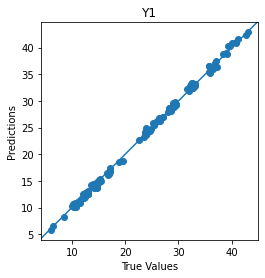

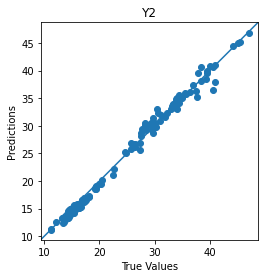

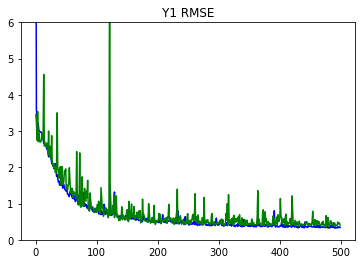

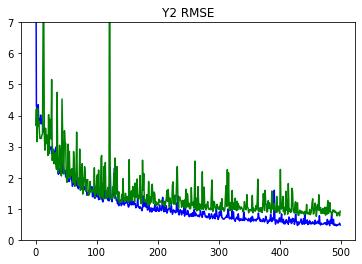

In [8]:
# Plot the loss and mse
Y_pred = model.predict(norm_test_X)
plot_diff(test_Y[0], Y_pred[0], title='Y1')
plot_diff(test_Y[1], Y_pred[1], title='Y2')
plot_metrics(metric_name='y1_output_root_mean_squared_error', title='Y1 RMSE', ylim=6)
plot_metrics(metric_name='y2_output_root_mean_squared_error', title='Y2 RMSE', ylim=7)